In [220]:
from pathlib import Path
import cv2
import imutils
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
from skimage.segmentation import clear_border

In [221]:
def read_img(img_path, grayscale=True):
    if grayscale:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(img_path)
    return img

def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [222]:
image_path = Path("images") / "sudoku.jpeg"
img = read_img(str(image_path), grayscale=False)
model = load_model(str(Path.cwd() / "ocr_output" / "new_model-2.h5"))

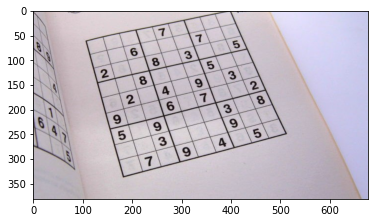

In [223]:
imshow(img)

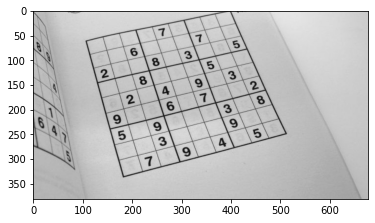

In [224]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

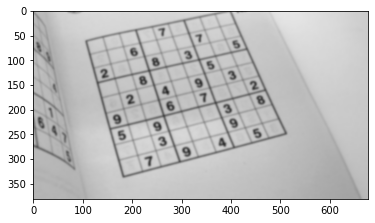

In [225]:
blurred = cv2.GaussianBlur(gray, (9, 9), 0)
imshow(blurred)

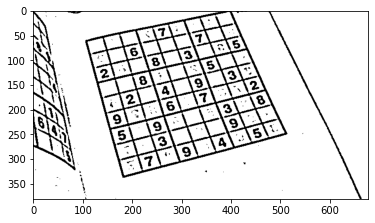

In [226]:
threshhold = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
imshow(threshhold)

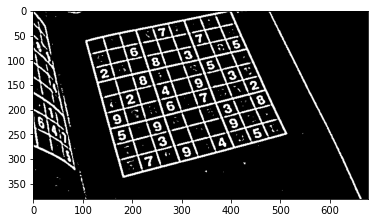

In [227]:
threshhold = cv2.bitwise_not(threshhold)
imshow(threshhold)

In [228]:
contours = cv2.findContours(threshhold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

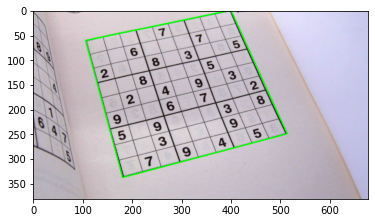

In [229]:
puzzle_contour = None

class NoPuzzleFoundException(Exception):
    pass

for c in contours:
    p = cv2.arcLength(c, True)
    approx_contour = cv2.approxPolyDP(c, 0.02 * p, True)
    
    if len(approx_contour) == 4:
        puzzle_contour = approx_contour
        break
        
if puzzle_contour is None:
    raise NoPuzzleFoundException(
            "Outline of the sudoku puzzle could not be found. Consider modifying threshold parameters"
        )
output = img.copy()
cv2.drawContours(output, [puzzle_contour], -1, (0,255,0), 2)
imshow(output)

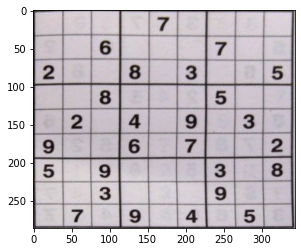

In [230]:
puzzle_image = four_point_transform(img, puzzle_contour.reshape(4,2))
imshow(puzzle_image)

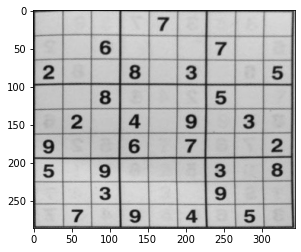

In [231]:
warped_image = four_point_transform(gray, puzzle_contour.reshape(4,2))
imshow(warped_image)

### Find Cells

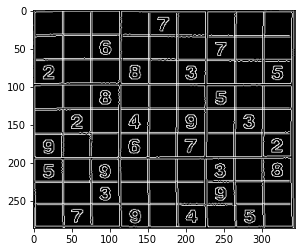

In [232]:
board = np.zeros((9,9), dtype="int")

edges = cv2.Canny(warped_image, 90, 150, apertureSize=3)
imshow(edges)

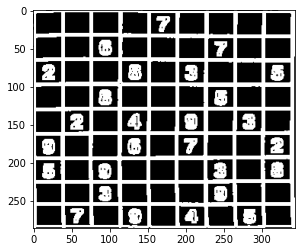

In [233]:
kernel = np.ones((3,3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
imshow(edges)

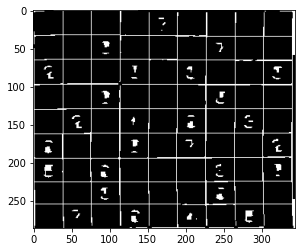

In [234]:
kernel = np.ones((5,5), np.uint8)
edges = cv2.erode(edges, kernel, iterations=1)
imshow(edges)

In [235]:
lines = cv2.HoughLines(edges, 1, np.pi / 180, 145)
if not lines.any():
    print("No grid was found")
    
filter = True
if filter:
    rho_threshold = 15
    theta_threshold = 0.1
    
    similar_lines = {i: [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue
            rho_i, theta_i = lines[i][0]
            rho_j, theta_j = lines[j][0]
            if (
                abs(rho_i - rho_j) < rho_threshold
                and abs(theta_i - theta_j) < theta_threshold
            ):
                similar_lines[i].append(j)

    indicies = [i for i in range(len(lines))]
    indicies.sort(key=lambda x: len(similar_lines[x]))

    line_flags = len(lines) * [True]
    for i in range(len(lines) - 1):
        if not line_flags[indicies[i]]:
            continue
        for j in range(i + 1, len(lines)):
            if not line_flags[indicies[j]]:
                continue

            rho_i, theta_i = lines[indicies[i]][0]
            rho_j, theta_j = lines[indicies[j]][0]
            if (
                abs(rho_i - rho_j) < rho_threshold
                and abs(theta_i - theta_j) < theta_threshold
            ):
                line_flags[indicies[j]] = False
print(f"Number of Hough Lines: {len(lines)}")    

Number of Hough Lines: 23


In [236]:
filtered_lines = []

if filter:
    for i in range(len(lines)):
        if line_flags[i]:
            filtered_lines.append(lines[i])
    print(f"Number of filtered lines: {len(filtered_lines)}")
else:
    filtered_lines = lines

Number of filtered lines: 20


In [237]:
def is_vertical_grid_line(p1, p2, threshhold=10):  
    x1, y1 = p1
    x2, y2 = p2
    if abs(x1 - x2) < threshhold:
        return True
    return False

vertical_lines = []
horizontal_lines = []
for line in filtered_lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    grid_line = ((x1, y1), (x2, y2))

    if is_vertical_grid_line(grid_line[0], grid_line[1]):
        vertical_lines.append(grid_line)
    else:
        horizontal_lines.append(grid_line)

In [238]:
horizontal_lines

[((-1000, 96), (999, 97)),
 ((-1000, 128), (999, 129)),
 ((-1000, 253), (999, 254)),
 ((-1000, 160), (999, 161)),
 ((-1000, 224), (999, 225)),
 ((-1000, 193), (999, 194)),
 ((-1000, 64), (999, 65)),
 ((-1000, 33), (999, 34)),
 ((-1000, 284), (999, 285)),
 ((-1000, 0), (1000, 0))]

In [239]:
vertical_lines

[((39, 1000), (39, -1000)),
 ((340, 1000), (340, -1000)),
 ((114, 1000), (114, -1000)),
 ((0, 1000), (0, -1000)),
 ((76, 1000), (76, -1000)),
 ((227, 1000), (227, -1000)),
 ((189, 1000), (189, -1000)),
 ((152, 1000), (152, -1000)),
 ((302, 1000), (302, -1000)),
 ((265, 1000), (265, -1000))]

In [240]:
def line_intersection(line1, line2):
    T = np.array([[0, -1], [1, 0]])
    a1, a2 = list(map(np.asarray, line1))
    b1, b2 = list(map(np.asarray, line2))

    da = np.atleast_2d(a2 - a1)
    db = np.atleast_2d(b2 - b1)
    dp = np.atleast_2d(a1 - b1)
    dap = np.dot(da, T)
    denominator = np.sum(dap * db, axis=1)
    numerator = np.sum(dap * dp, axis=1)
    return tuple((np.atleast_2d(numerator / denominator).T * db + b1).astype(int)[0])

In [241]:
intersections = []
for h_line in horizontal_lines:
    row = []
    for v_line in vertical_lines:
        intersect = line_intersection(v_line, h_line)
        row.append(intersect)
    row.sort(key=lambda x: x[0])
    intersections.append(row)
intersections.sort(key=lambda x: x[0][1])

In [243]:
warped_image.shape

(286, 344)

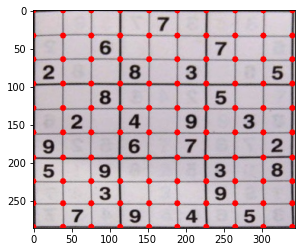

In [244]:
intersect_img = puzzle_image.copy()
for row in intersections:
    for point in row:
        cv2.circle(intersect_img, point, radius=4, color=(0, 0, 255), thickness=-1)
imshow(intersect_img)

In [245]:
intersections = np.array(intersections, dtype="int")
intersections.shape

(10, 10, 2)

In [246]:
if intersections.shape != (10, 10, 2):
    raise Exception("grid not fuully detected")

In [247]:
cells = np.zeros((9,9,4), np.uint32)
verts = intersections
for row in range(len(verts) - 1):
    for col in range(len(verts[row]) - 1):
        leftX, topY = verts[row][col]
        rightX, bottomY = verts[row + 1][col + 1]
        cell = (leftX, topY, rightX, bottomY)
        cells[row][col] = cell

#cells
#cells = np.sort(cells, axis=1)

[0 0]
[39 33]
[39  0]
[76 33]
[76  0]
[114  33]
[114   0]
[152  33]
[152   0]
[189  33]
[189   0]
[227  33]
[227   0]
[265  33]
[265   0]
[302  33]
[302   0]
[340  33]
[ 0 33]
[39 64]
[39 33]
[76 64]
[76 33]
[114  64]
[114  33]
[152  64]
[152  33]
[189  64]
[189  33]
[227  64]
[227  33]
[265  64]
[265  33]
[302  64]
[302  33]
[340  64]
[ 0 64]
[39 96]
[39 64]
[76 96]
[76 64]
[114  96]
[114  64]
[152  96]
[152  64]
[189  96]
[189  64]
[227  96]
[227  64]
[265  96]
[265  64]
[302  96]
[302  64]
[340  96]
[ 0 96]
[ 39 128]
[39 96]
[ 76 128]
[76 96]
[114 128]
[114  96]
[152 128]
[152  96]
[189 128]
[189  96]
[227 128]
[227  96]
[265 128]
[265  96]
[302 128]
[302  96]
[340 128]
[  0 128]
[ 39 160]
[ 39 128]
[ 76 160]
[ 76 128]
[114 160]
[114 128]
[152 160]
[152 128]
[189 160]
[189 128]
[227 160]
[227 128]
[265 160]
[265 128]
[302 160]
[302 128]
[340 160]
[  0 160]
[ 39 193]
[ 39 160]
[ 76 193]
[ 76 160]
[114 193]
[114 160]
[152 193]
[152 160]
[189 193]
[189 160]
[227 193]
[227 160]
[265 193

In [248]:
for row in verts:
    print(row.view(type=np.matrix))

[[  0   0]
 [ 39   0]
 [ 76   0]
 [114   0]
 [152   0]
 [189   0]
 [227   0]
 [265   0]
 [302   0]
 [340   0]]
[[  0  33]
 [ 39  33]
 [ 76  33]
 [114  33]
 [152  33]
 [189  33]
 [227  33]
 [265  33]
 [302  33]
 [340  33]]
[[  0  64]
 [ 39  64]
 [ 76  64]
 [114  64]
 [152  64]
 [189  64]
 [227  64]
 [265  64]
 [302  64]
 [340  64]]
[[  0  96]
 [ 39  96]
 [ 76  96]
 [114  96]
 [152  96]
 [189  96]
 [227  96]
 [265  96]
 [302  96]
 [340  96]]
[[  0 128]
 [ 39 128]
 [ 76 128]
 [114 128]
 [152 128]
 [189 128]
 [227 128]
 [265 128]
 [302 128]
 [340 128]]
[[  0 160]
 [ 39 160]
 [ 76 160]
 [114 160]
 [152 160]
 [189 160]
 [227 160]
 [265 160]
 [302 160]
 [340 160]]
[[  0 193]
 [ 39 193]
 [ 76 193]
 [114 193]
 [152 193]
 [189 193]
 [227 193]
 [265 193]
 [302 193]
 [340 193]]
[[  0 224]
 [ 39 224]
 [ 76 224]
 [114 224]
 [152 224]
 [189 224]
 [227 224]
 [265 224]
 [302 224]
 [340 224]]
[[  0 253]
 [ 39 253]
 [ 76 253]
 [114 253]
 [152 253]
 [189 253]
 [227 253]
 [265 253]
 [302 253]
 [340 253]]
[

In [249]:
verts[1][1]

array([39, 33])

In [250]:

cells

array([[[  0,   0,  39,  33],
        [ 39,   0,  76,  33],
        [ 76,   0, 114,  33],
        [114,   0, 152,  33],
        [152,   0, 189,  33],
        [189,   0, 227,  33],
        [227,   0, 265,  33],
        [265,   0, 302,  33],
        [302,   0, 340,  33]],

       [[  0,  33,  39,  64],
        [ 39,  33,  76,  64],
        [ 76,  33, 114,  64],
        [114,  33, 152,  64],
        [152,  33, 189,  64],
        [189,  33, 227,  64],
        [227,  33, 265,  64],
        [265,  33, 302,  64],
        [302,  33, 340,  64]],

       [[  0,  64,  39,  96],
        [ 39,  64,  76,  96],
        [ 76,  64, 114,  96],
        [114,  64, 152,  96],
        [152,  64, 189,  96],
        [189,  64, 227,  96],
        [227,  64, 265,  96],
        [265,  64, 302,  96],
        [302,  64, 340,  96]],

       [[  0,  96,  39, 128],
        [ 39,  96,  76, 128],
        [ 76,  96, 114, 128],
        [114,  96, 152, 128],
        [152,  96, 189, 128],
        [189,  96, 227, 128],
    

In [251]:
def extract_digit(cell):
    threshhold = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    threshhold = clear_border(threshhold)

    contours = cv2.findContours(
        threshhold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = imutils.grab_contours(contours)

    if len(contours) == 0:
        return None

    c = max(contours, key=cv2.contourArea)
    mask = np.zeros(threshhold.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = threshhold.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    if percentFilled < 0.03:
        return None

    digit = cv2.bitwise_and(threshhold, threshhold, mask=mask)


    return digit

digits = []
for y, row in enumerate(cells):
    d_row = np.zeros((28, 28))
    for x, cell in enumerate(row):
        leftX, topY, rightX, bottomY = cell
        cell_contents = warped_image[topY:bottomY, leftX:rightX]
        digit = extract_digit(cell_contents)
        if digit is not None:
            roi = cv2.resize(digit, (28, 28))
            d_row = np.concatenate((d_row, roi), axis=1)
            roi = roi.astype("float") / 255.0 
            roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis=0)
            pred_all = model.predict(roi)
            pred = pred_all.argmax(axis=-1)[0]
            print(pred)
            board[y,x] = pred
        else:
            zeros =np.zeros((28,28))
            d_row = np.concatenate((d_row, zeros), axis=1)
    digits.append(d_row)





7
6
7
2
8
3
5
8
5
2
4
9
3
9
6
7
2
5
9
3
8
3
9
7
9
4
5


In [252]:
all_digits = np.concatenate((digits[0],digits[1],digits[2],digits[3],digits[4],digits[5],digits[6],digits[7],digits[8]), axis=0)

In [253]:
digits[0].shape

(28, 280)

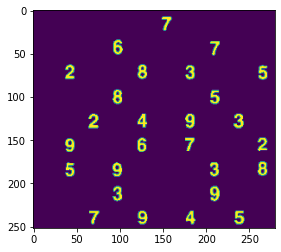

In [254]:
plt.imshow(all_digits)

In [255]:
board

array([[0, 0, 0, 0, 7, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0, 7, 0, 0],
       [2, 0, 0, 8, 0, 3, 0, 0, 5],
       [0, 0, 8, 0, 0, 0, 5, 0, 0],
       [0, 2, 0, 4, 0, 9, 0, 3, 0],
       [9, 0, 0, 6, 0, 7, 0, 0, 2],
       [5, 0, 9, 0, 0, 0, 3, 0, 8],
       [0, 0, 3, 0, 0, 0, 9, 0, 0],
       [0, 7, 0, 9, 0, 4, 0, 5, 0]])

In [256]:
expected = np.array([[0, 0, 0, 0, 7, 0, 0, 0, 0],
                     [0, 0, 6, 0, 0, 0, 7, 0, 0],
                     [2, 0, 0, 8, 0, 3, 0, 0, 5],
                     [0, 0, 8, 0, 0, 0, 5, 0, 0],
                     [0, 2, 0, 4, 0, 9, 0, 3, 0],
                     [9, 0, 0, 6, 0, 7, 0, 0, 2],
                     [5, 0, 9, 0, 0, 0, 3, 0, 8],
                     [0, 0, 3, 0, 0, 0, 9, 0, 0],
                     [0, 7, 0, 9, 0, 4, 0, 5, 0]])

In [257]:
board - expected

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])